## **1 Denoising Autoencoder**

# Importing necessary libraries

In [ ]:
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Dataset

In [ ]:
#Providing path for dataset
train = '/content/drive/MyDrive/DL_Lab9/denoising-dirty-documents (1)/train'
train_cleaned = '/content/drive/MyDrive/DL_Lab9/denoising-dirty-documents (1)/train_cleaned'
test = '/content/drive/MyDrive/DL_Lab9/denoising-dirty-documents (1)/test'

In [ ]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


In [ ]:
samples = train_images[:3] +train_labels[:3]

# Train Images

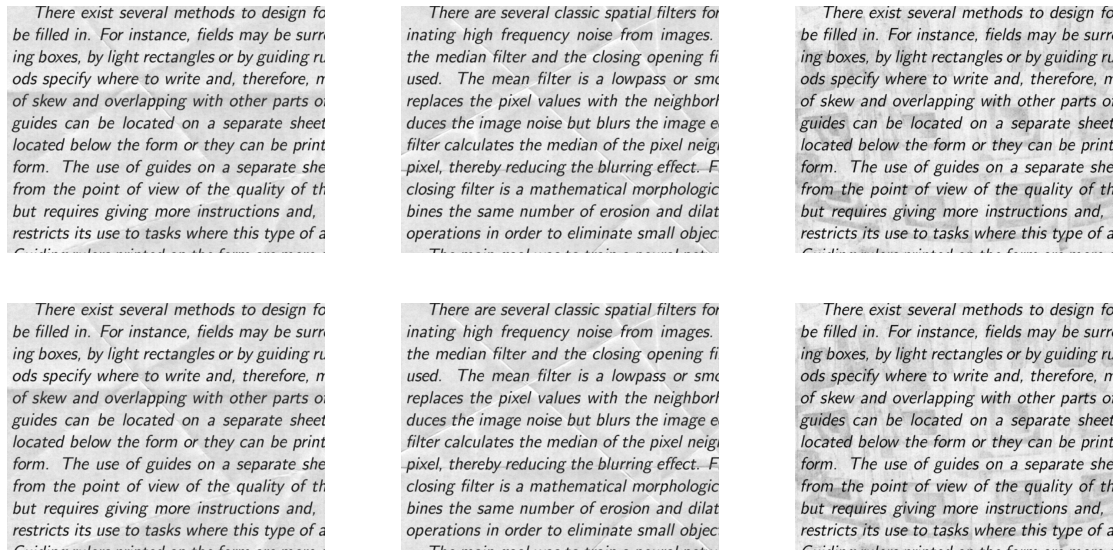

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img_path = train + '/' + img
    img = imread(img_path)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')


# Clean Images

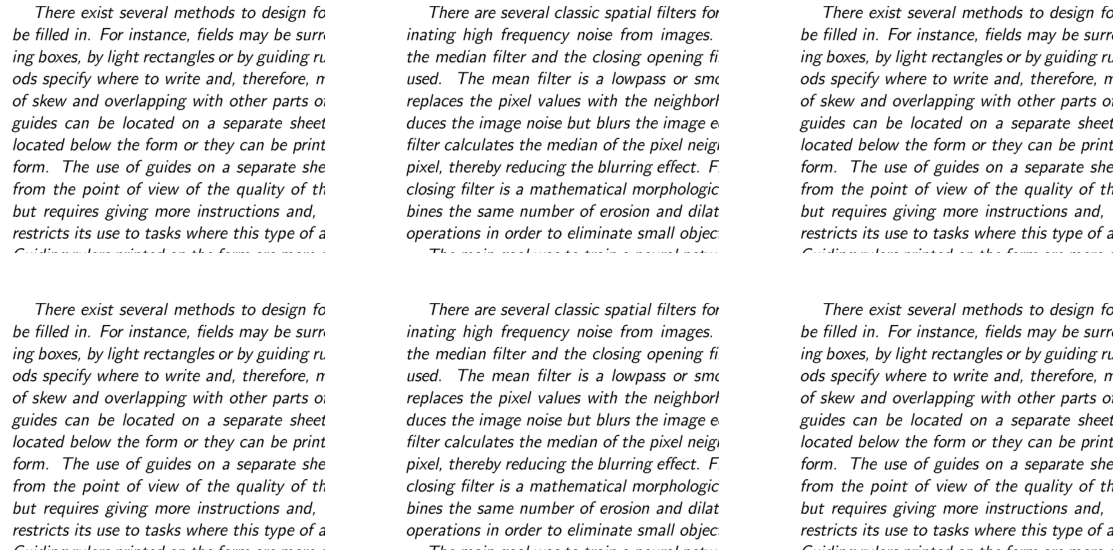

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img_path = train_cleaned + '/' + img
    img = imread(img_path)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')

# Build Autoencoder

In [ ]:
import keras
from keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization
def build_autoenocder():
    input_img = keras.Input(shape=(420,540,1))

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x=  BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [ ]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 420, 540, 128)     1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 210, 270, 128)    0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 210, 270, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 210, 270, 256)     295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 105, 135, 256)    0   

# Train Model

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X = []
Y = []
for img in train_images:
    img_path = os.path.join(train, img)  # concatenate directory path and filename
    img = load_img(img_path, color_mode = "grayscale", target_size=(420, 540))
    img = img_to_array(img).astype('float32') / 255.0  # normalize
    X.append(img)

for img in train_images:
    img_path = os.path.join(train_cleaned, img)  # concatenate directory path and filename
    img = load_img(img_path, color_mode = "grayscale", target_size=(420, 540))
    img = img_to_array(img).astype('float32') / 255.0  # normalize
    Y.append(img)




X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [ ]:
import tensorflow as tf

#Callback function
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('loss')<0.001):
            print("\nReached 90% accuracy so cancelling training")
            self.model.stop_training=True

In [ ]:
callbacks=myCallBack()

In [ ]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_valid, y_valid),callbacks=[callbacks])

Epoch 1/100
 6/65 [=>............................] - ETA: 11s - loss: 0.4658

65/65 [==============================] - 23s 247ms/step - loss: 0.2536 - val_loss: 1.0517
Epoch 2/100
65/65 [==============================] - 13s 201ms/step - loss: 0.2127 - val_loss: 1.7653
Epoch 3/100
65/65 [==============================] - 13s 204ms/step - loss: 0.1872 - val_loss: 2.0848
Epoch 4/100
65/65 [==============================] - 13s 206ms/step - loss: 0.1606 - val_loss: 2.0770
Epoch 5/100
65/65 [==============================] - 14s 208ms/step - loss: 0.1443 - val_loss: 1.8437
Epoch 6/100
65/65 [==============================] - 14s 209ms/step - loss: 0.1356 - val_loss: 1.4691
Epoch 7/100
65/65 [==============================] - 14s 210ms/step - loss: 0.1276 - val_loss: 1.1511
Epoch 8/100
65/65 [==============================] - 14s 209ms/step - loss: 0.1213 - val_loss: 0.9352
Epoch 9/100
65/65 [==============================] - 13s 207ms/step - loss: 0.1169 - val_loss: 0.5468
Epoch 10/100
65/65 [==============================] - 13s 207ms/step - loss: 0.1125 - val_loss

# Plot Results

1/1 [==============================] - 0s 60ms/step


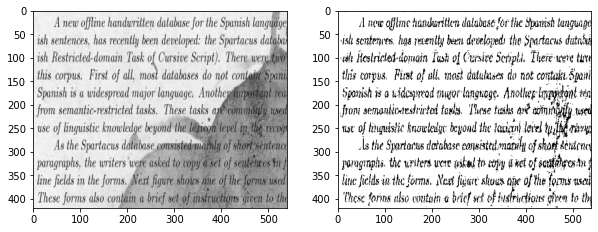

1/1 [==============================] - 0s 34ms/step


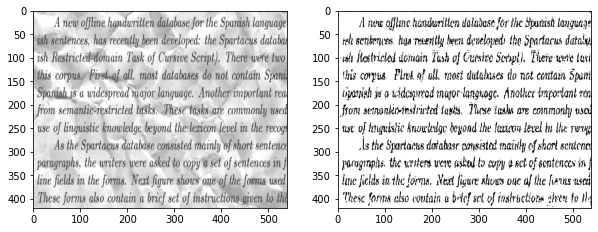

1/1 [==============================] - 0s 26ms/step


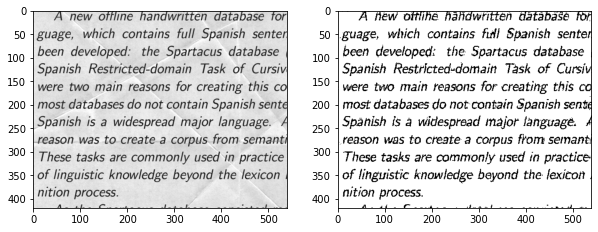

1/1 [==============================] - 0s 21ms/step


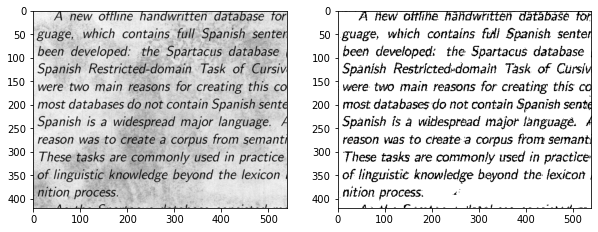

1/1 [==============================] - 0s 21ms/step


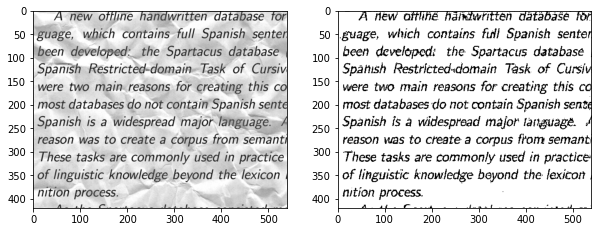

1/1 [==============================] - 0s 33ms/step


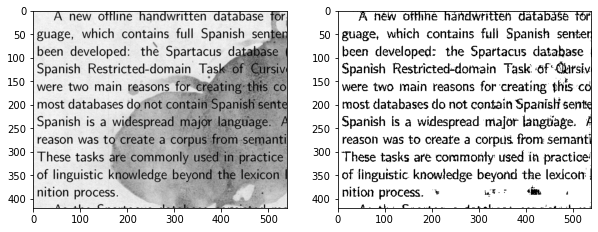

1/1 [==============================] - 0s 19ms/step


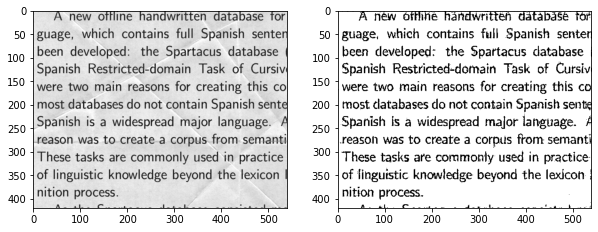

1/1 [==============================] - 0s 29ms/step


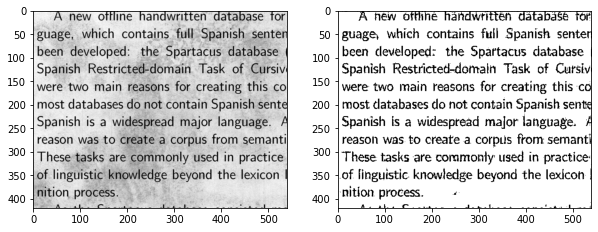

1/1 [==============================] - 0s 22ms/step


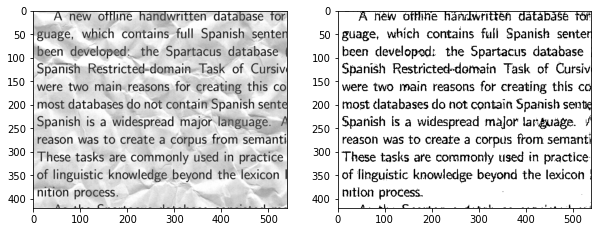

1/1 [==============================] - 0s 19ms/step


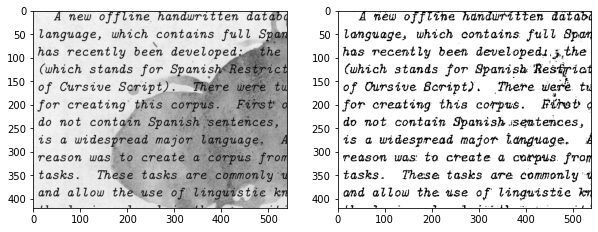

In [ ]:
for i in range(10): # load and predict the first 10 test images
    sample_test = load_img(test + "/" + test_images[i], grayscale=True, target_size=(420,540))
    sample_test = img_to_array(sample_test)
    sample_test_img = sample_test.astype('float32')/255.
    sample_test_img = np.expand_dims(sample_test, axis=0)

    # Get the predition
    predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

    f, ax = plt.subplots(1,2, figsize=(10,8))
    ax[0].imshow(np.squeeze(sample_test), cmap='gray')
    ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
    plt.show()
